## Introduction
In this notebook, we will simulate predator-prey dynamics using the Lotka-Volterra equations and use **AutoGluon-TimeSeries** to forecast the future population of predators and prey.

### Key Objectives:
1. Generate synthetic time series data using the Lotka-Volterra equations.
2. Add real-world noise to simulate imperfect data.
3. Prepare the dataset for AutoGluon-TimeSeries.
4. Forecast predator and prey populations using Chronos models.
5. Visualize and analyze the results.


In [3]:
# Install required libraries
!pip install numpy pandas scipy matplotlib scikit-learn autogluon.timeseries


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.4/40.4 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.7/174.7 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.2/68.2 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.2/266.2 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 352.2/352.2 kB 25.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.7/196.7 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.0/71.0 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.1/64.1 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 59.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 324.4/324.4 kB 23.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.2/278.2 kB 19.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 52.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8

## Step 1: Generate Synthetic Data
The Lotka-Volterra equations are a pair of first-order, non-linear differential equations frequently used to describe the dynamics of biological systems in which two species interact as predator and prey.

Below, we:
1. Define the Lotka-Volterra equations.
2. Solve them numerically using `scipy.integrate.solve_ivp`.
3. Add Gaussian noise to simulate real-world conditions.


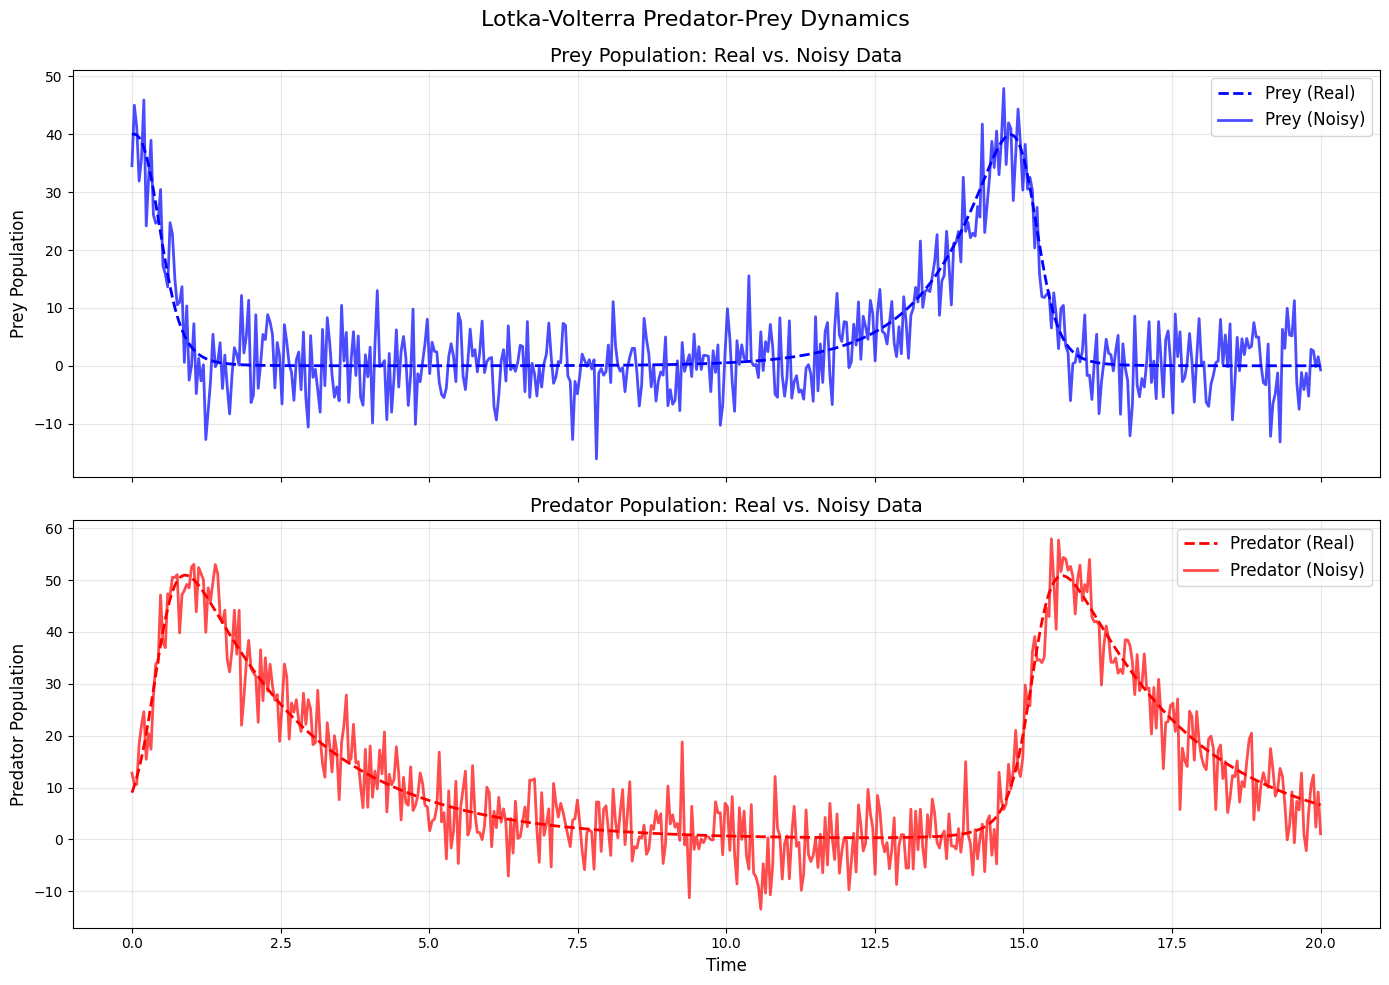

In [9]:
import numpy as np
import pandas as pd
from scipy.integrate import solve_ivp

# Define the Lotka-Volterra equations
def lotka_volterra(t, z, alpha, beta, delta, gamma):
    x, y = z
    dxdt = alpha * x - beta * x * y
    dydt = delta * x * y - gamma * y
    return [dxdt, dydt]

# Parameters for the predator-prey model
alpha, beta, delta, gamma = 1.0, 0.1, 0.1, 0.5
initial_conditions = [40, 9]  # Initial prey and predator populations
time_span = (0, 20)  # Simulate for 20 units of time
time_points = np.linspace(0, 20, 500)  # Generate 500 time points

# Solve the equations
solution = solve_ivp(
    lotka_volterra, time_span, initial_conditions, t_eval=time_points, args=(alpha, beta, delta, gamma)
)
prey, predator = solution.y  # Extract prey and predator populations

# Add Gaussian noise
noise_level = 5.0
noisy_prey = prey + np.random.normal(0, noise_level, size=prey.shape)
noisy_predator = predator + np.random.normal(0, noise_level, size=predator.shape)

# Visualize the generated data
import matplotlib.pyplot as plt

# Plot: Real vs Noisy Data
fig, axes = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# Prey Population Plot
axes[0].plot(time_points, prey, label="Prey (Real)", color="blue", linestyle="dashed", linewidth=2)
axes[0].plot(time_points, noisy_prey, label="Prey (Noisy)", color="blue", alpha=0.7, linewidth=2)
axes[0].set_title("Prey Population: Real vs. Noisy Data", fontsize=14)
axes[0].set_ylabel("Prey Population", fontsize=12)
axes[0].legend(fontsize=12)
axes[0].grid(alpha=0.3)

# Predator Population Plot
axes[1].plot(time_points, predator, label="Predator (Real)", color="red", linestyle="dashed", linewidth=2)
axes[1].plot(time_points, noisy_predator, label="Predator (Noisy)", color="red", alpha=0.7, linewidth=2)
axes[1].set_title("Predator Population: Real vs. Noisy Data", fontsize=14)
axes[1].set_xlabel("Time", fontsize=12)
axes[1].set_ylabel("Predator Population", fontsize=12)
axes[1].legend(fontsize=12)
axes[1].grid(alpha=0.3)

# Adjust layout
fig.suptitle("Lotka-Volterra Predator-Prey Dynamics", fontsize=16)
fig.tight_layout()
plt.subplots_adjust(top=0.92)  # Adjust space for the main title
plt.show()


## Step 2: Prepare the Dataset
AutoGluon expects time series data in a specific format:
- **item_id**: Identifier for each time series.
- **timestamp**: Time index for the observations.
- **target**: Values to be forecasted.

We will:
1. Assign a unique `item_id` for prey and predator.
2. Combine both series into a single DataFrame.
3. Save the data for AutoGluon.


In [28]:
# Generate regular timestamps
timestamps = pd.date_range(start="2025-01-01", periods=len(time_points), freq="1D")

# Create prey and predator DataFrames
prey_data = pd.DataFrame({
    "item_id": "prey_series",
    "timestamp": timestamps,
    "target": noisy_prey
})

predator_data = pd.DataFrame({
    "item_id": "predator_series",
    "timestamp": timestamps,
    "target": noisy_predator
})

# Add a column to each table representing the values of the other
prey_data["other_target"] = noisy_predator  # Add predator values to prey table
predator_data["other_target"] = noisy_prey  # Add prey values to predator table

# Combine the datasets
combined_data = pd.concat([prey_data, predator_data], ignore_index=True)

# Save the combined dataset
combined_data.to_csv("prey_predator_time_series.csv", index=False)

# Display the first few rows
combined_data.head()



,item_id,timestamp,target,other_target
0,prey_series,2025-01-01,34.571847,12.760168
1,prey_series,2025-01-02,45.040860,10.705450
2,prey_series,2025-01-03,41.291465,10.587956
3,prey_series,2025-01-04,31.913703,18.332849
4,prey_series,2025-01-05,35.828214,21.989881


## Step 3: Explore Chronos Configurations and Choose the Best Model
In this section, we explore different Chronos configurations and hyperparameters to identify the best-performing forecasting model for our synthetic time series data.

Chronos models are pretrained and support fine-tuning. We will test configurations such as:
- Pretrained models of varying sizes (`bolt_tiny`, `bolt_small`, etc.).
- Fine-tuned models of varying sizes.
- Incorporating covariates to Fine-tuned models of varying sizes.



In [36]:
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import pandas as pd
import numpy as np

data = TimeSeriesDataFrame.from_path("prey_predator_time_series.csv")
prediction_length = 48
train_data, test_data = data.train_test_split(prediction_length)

predictor = TimeSeriesPredictor(
    prediction_length=prediction_length,
    target="target",
    known_covariates_names=["other_target"],
).fit(
train_data=train_data,
hyperparameters={
    "Chronos": [
        {"model_path": "bolt_tiny", "ag_args": {"name_suffix": "ZeroShot"}},
        {"model_path": "bolt_tiny", "fine_tune": True, "ag_args": {"name_suffix": "FineTuned"}},
        {"model_path": "bolt_tiny","fine_tune": True,"covariate_regressor": "CAT","target_scaler": "standard","ag_args": {"name_suffix": "WithRegressor"},},
        {"model_path": "bolt_small", "ag_args": {"name_suffix": "ZeroShot"}},
        {"model_path": "bolt_small", "fine_tune": True, "ag_args": {"name_suffix": "FineTuned"}},
        {"model_path": "bolt_small","fine_tune": True,"covariate_regressor": "CAT","target_scaler": "standard","ag_args": {"name_suffix": "WithRegressor"},},
        {"model_path": "bolt_mini", "ag_args": {"name_suffix": "ZeroShot"}},
        {"model_path": "bolt_mini", "fine_tune": True, "ag_args": {"name_suffix": "FineTuned"}},
        {"model_path": "bolt_mini","fine_tune": True,"covariate_regressor": "CAT","target_scaler": "standard","ag_args": {"name_suffix": "WithRegressor"},},
        {"model_path": "bolt_base", "ag_args": {"name_suffix": "ZeroShot"}},
        {"model_path": "bolt_base", "fine_tune": True, "ag_args": {"name_suffix": "FineTuned"}},
        {"model_path": "bolt_base","fine_tune": True,"covariate_regressor": "CAT","target_scaler": "standard","ag_args": {"name_suffix": "WithRegressor"},},
    ]
},
time_limit=1800,  # time limit in seconds
enable_ensemble=False,
)

predictor.leaderboard(test_data)


Sorting the dataframe index before generating the train/test split.
Beginning AutoGluon training... Time limit = 1800s
AutoGluon will save models to '/content/AutogluonModels/ag-20250127_204406'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       9.03 GB / 12.67 GB (71.2%)
Disk Space Avail:   60.01 GB / 107.72 GB (55.7%)

Fitting with arguments:
{'enable_ensemble': False,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': [{'ag_args': {'name_suffix': 'ZeroShot'},
                                  'model_path': 'bolt_tiny'},
                                 {'ag_args': {'name_suffix': 'FineTuned'},
                                  'fine_tune': True,
                                  'model_path': 'bolt_tiny'},
                                 {'ag

,model,score_test,score_val,pred_time_test,pred_time_val,fit_time_marginal,fit_order
0,ChronosFineTuned[bolt_mini],-0.444842,-0.213541,1.264004,0.085071,195.486533,8
1,ChronosFineTuned[bolt_small],-0.451156,-0.220167,2.294837,0.127034,157.529495,5
2,ChronosFineTuned[bolt_base],-0.457757,-0.332607,3.865860,0.376596,350.970821,11
3,ChronosWithRegressor[bolt_mini],-0.462353,-0.223470,1.280059,0.075605,204.876947,9
4,ChronosWithRegressor[bolt_tiny],-0.465913,-0.245402,0.865252,0.084773,135.343542,3
5,ChronosFineTuned[bolt_tiny],-0.469916,-0.233946,1.143235,0.045768,132.695516,2
6,ChronosWithRegressor[bolt_small],-0.471158,-0.231115,2.167553,0.172543,161.369230,6
7,ChronosWithRegressor[bolt_base],-0.471262,-0.270381,1.179520,0.581353,382.939326,12
8,ChronosZeroShot[bolt_base],-0.547935,-0.424893,2.323170,5.748991,0.016478,10
9,ChronosZeroShot[bolt_mini],-0.949078,-0.391532,1.645935,1.120422,0.018052,7


## Step 4: Visualize Predictions
We will plot the actual vs. predicted populations for both prey and predator to evaluate the performance of the Chronos model.


Beginning AutoGluon training... Time limit = 500s
AutoGluon will save models to '/content/AutogluonModels/ag-20250127_172407'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       9.38 GB / 12.67 GB (74.0%)
Disk Space Avail:   62.51 GB / 107.72 GB (58.0%)

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'fine_tune': True, 'model_path': 'bolt_mini'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 48,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': False,
 'target': 'target',
 'time_limit': 500,
 'verbosity': 2}

Inferred time series frequency: 'D'
Provid

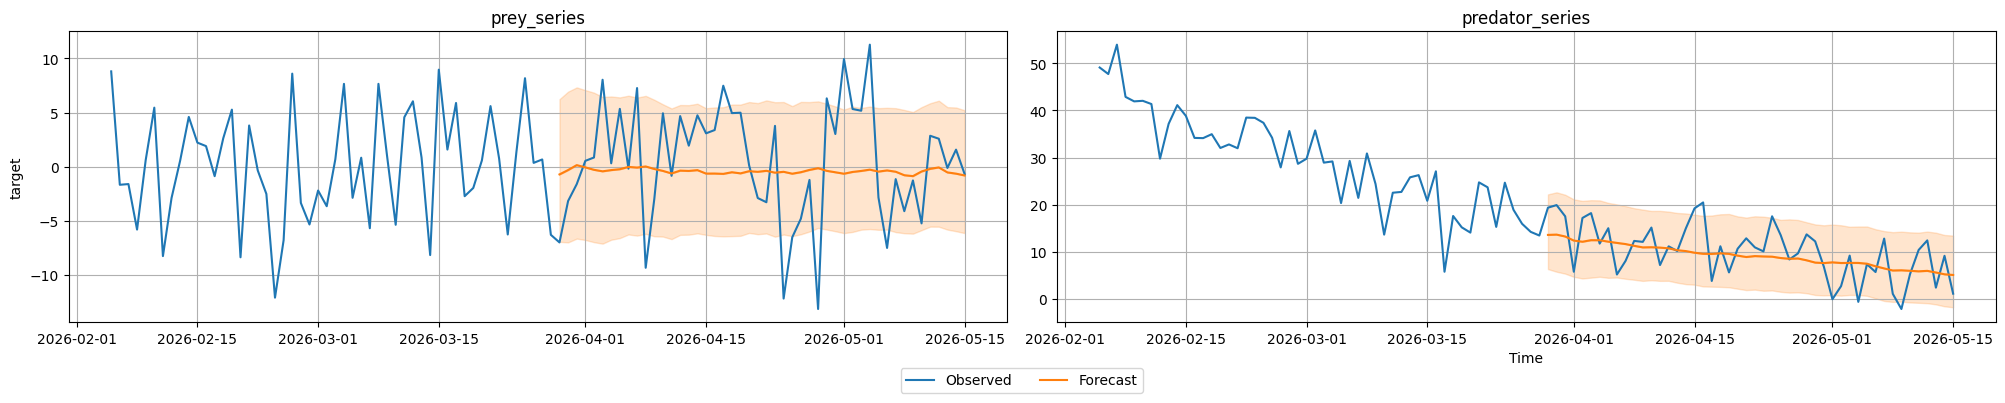

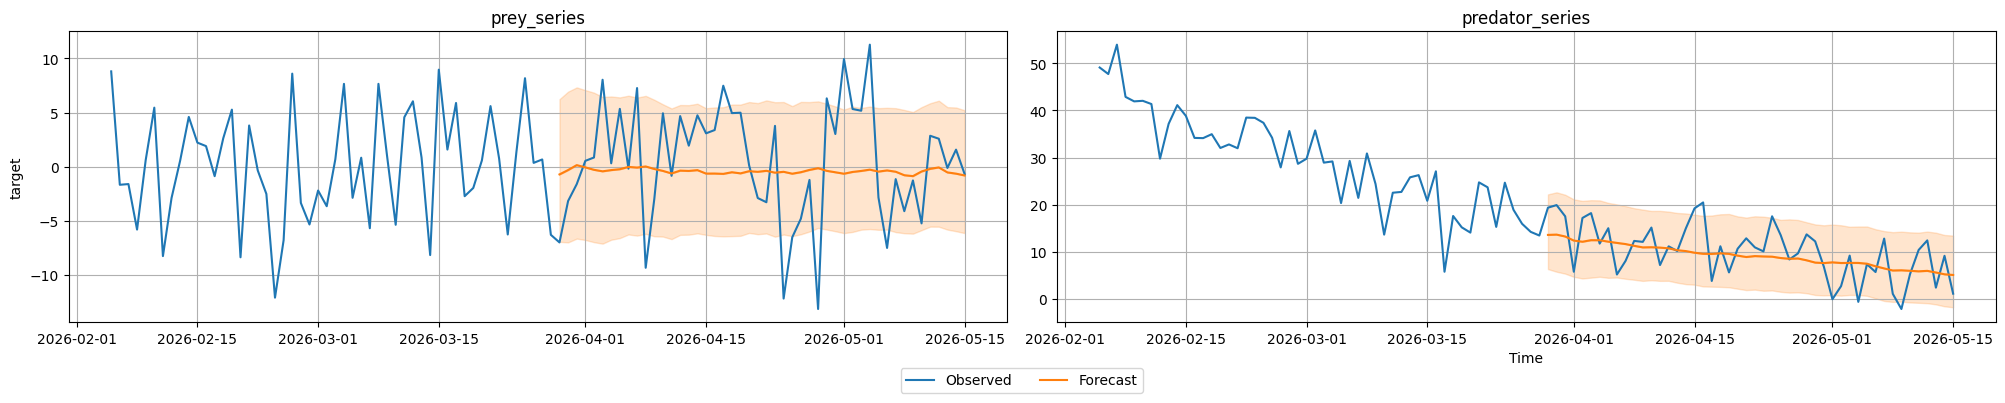

In [30]:
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor

predictor = TimeSeriesPredictor(prediction_length=prediction_length).fit(
    train_data=train_data, hyperparameters={
        "Chronos":
            {"model_path": "bolt_mini", "fine_tune": True},
    },time_limit=500,
)

predictions = predictor.predict(train_data)
# Visualize the predictions for both prey and predator
predictor.plot(
    data=data,
    predictions=predictions,
    item_ids=data.item_ids[:2],  # Plot the first two series (prey and predator)
    max_history_length=100,
)


## Step 5: Analyze and Evaluate Forecast Accuracy
In this section, we evaluate the accuracy of the Chronos forecasts using:
- **Mean Absolute Error (MAE)**
- **Root Mean Squared Error (RMSE)**


In [31]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Evaluate forecasts for prey
prey_actual = data.loc["prey_series", "target"][-prediction_length:]
prey_forecast = predictions.loc["prey_series", "mean"]
mae_prey = mean_absolute_error(prey_actual, prey_forecast)
rmse_prey = np.sqrt(mean_squared_error(prey_actual, prey_forecast))

# Evaluate forecasts for predator
predator_actual = data.loc["predator_series", "target"][-prediction_length:]
predator_forecast = predictions.loc["predator_series", "mean"]
mae_predator = mean_absolute_error(predator_actual, predator_forecast)
rmse_predator = np.sqrt(mean_squared_error(predator_actual, predator_forecast))

print(f"Prey Forecast - MAE: {mae_prey:.4f}, RMSE: {rmse_prey:.4f}")
print(f"Predator Forecast - MAE: {mae_predator:.4f}, RMSE: {rmse_predator:.4f}")


Prey Forecast - MAE: 4.3478, RMSE: 5.4388
Predator Forecast - MAE: 4.0548, RMSE: 4.8775


## Step 6: Visualize Actual vs. Predicted Data
To understand how well the model performed, we plot the actual vs. predicted populations for both prey and predator.


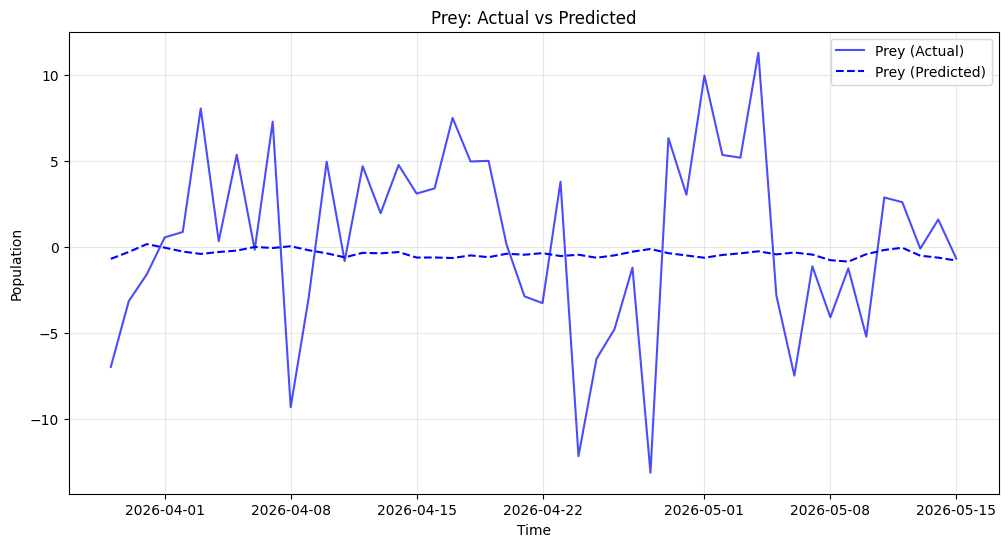

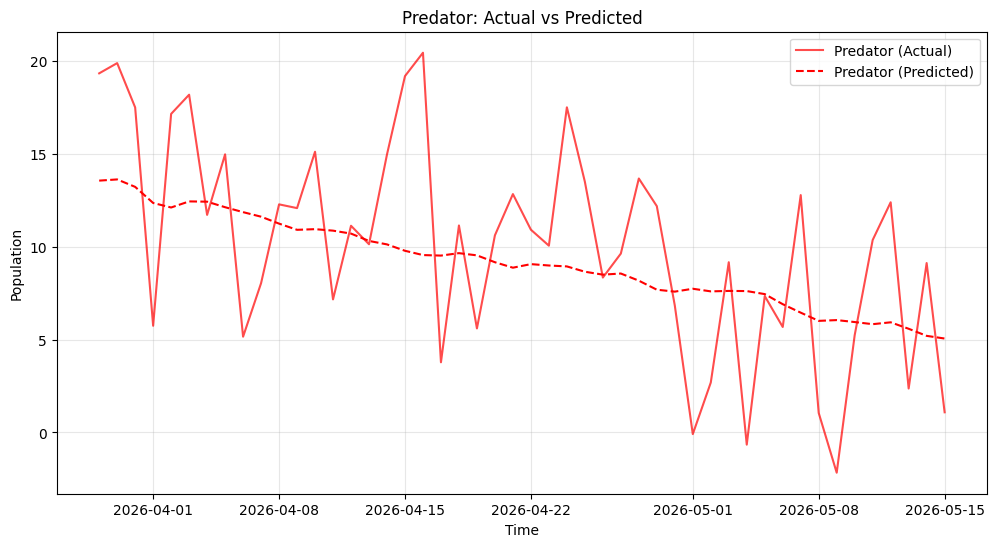

In [32]:
import matplotlib.pyplot as plt

# Prey: Actual vs Predicted
plt.figure(figsize=(12, 6))
plt.plot(prey_actual.index, prey_actual, label="Prey (Actual)", color="blue", alpha=0.7)
plt.plot(prey_forecast.index, prey_forecast, label="Prey (Predicted)", linestyle="dashed", color="blue")
plt.title("Prey: Actual vs Predicted")
plt.xlabel("Time")
plt.ylabel("Population")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Predator: Actual vs Predicted
plt.figure(figsize=(12, 6))
plt.plot(predator_actual.index, predator_actual, label="Predator (Actual)", color="red", alpha=0.7)
plt.plot(predator_forecast.index, predator_forecast, label="Predator (Predicted)", linestyle="dashed", color="red")
plt.title("Predator: Actual vs Predicted")
plt.xlabel("Time")
plt.ylabel("Population")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


## Step 7: Analyze the Impact of Noise
We analyze how different levels of Gaussian noise affect the forecasting accuracy. This is done by testing the model on data with varying noise levels and evaluating the MAE and RMSE metrics.


Sorting the dataframe index before generating the train/test split.
Beginning AutoGluon training... Time limit = 600s
AutoGluon will save models to '/content/AutogluonModels/ag-20250127_175115'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       9.43 GB / 12.67 GB (74.4%)
Disk Space Avail:   62.44 GB / 107.72 GB (58.0%)

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'fine_tune': True, 'model_path': 'bolt_mini'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 48,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': False,
 'target': 'target',
 'time_limit

   Noise Level  MAE (Prey)  RMSE (Prey)  MAE (Predator)  RMSE (Predator)
0          0.0    0.080139     0.110103        1.390210         1.395988
1          1.0    0.876930     1.099384        1.066407         1.291093
2          5.0    4.316003     5.409503        4.031399         4.851754
3         10.0    8.647638    10.800098        7.851017         9.567253


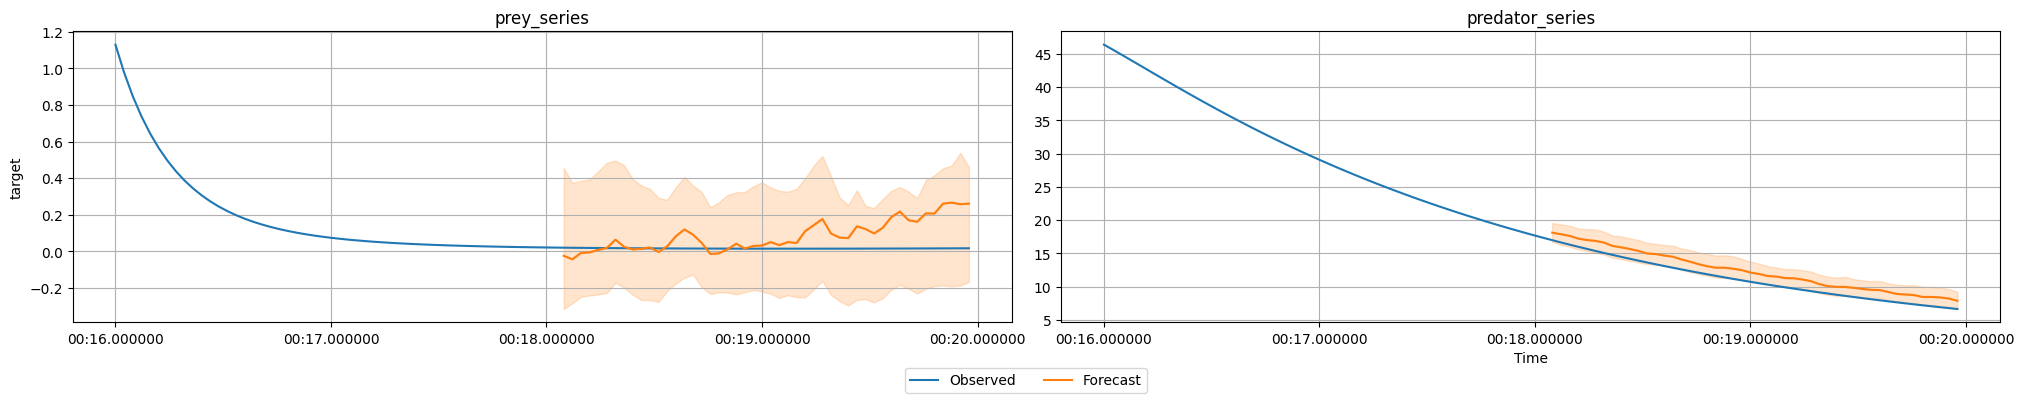

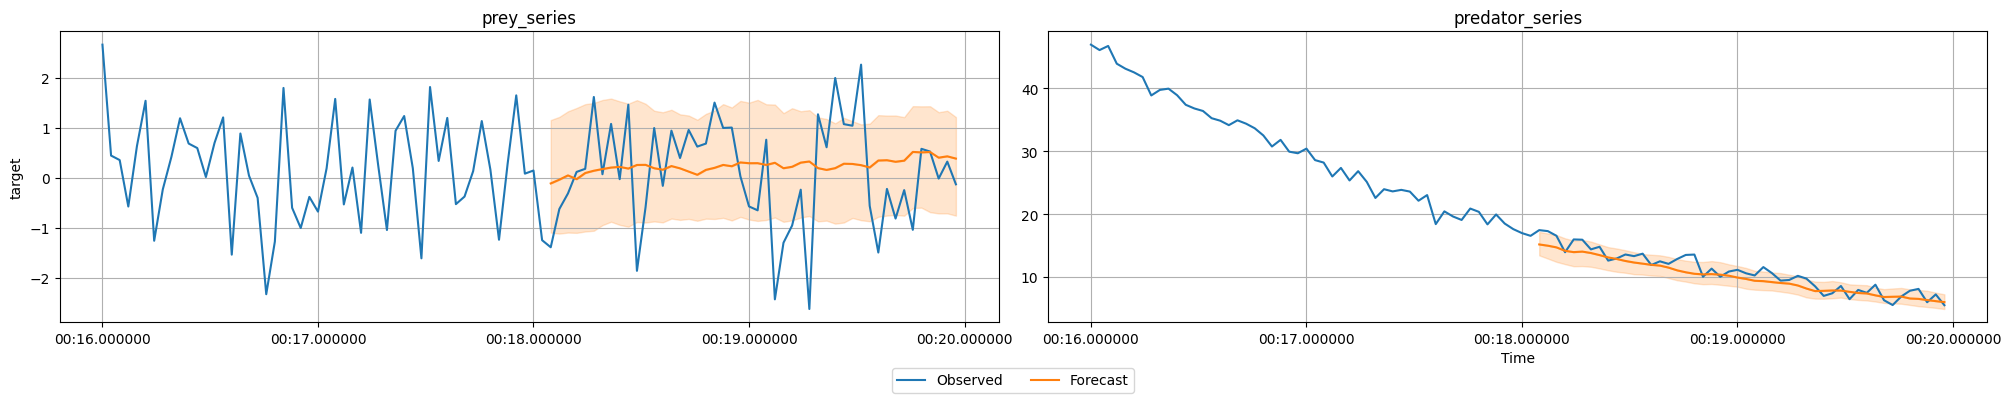

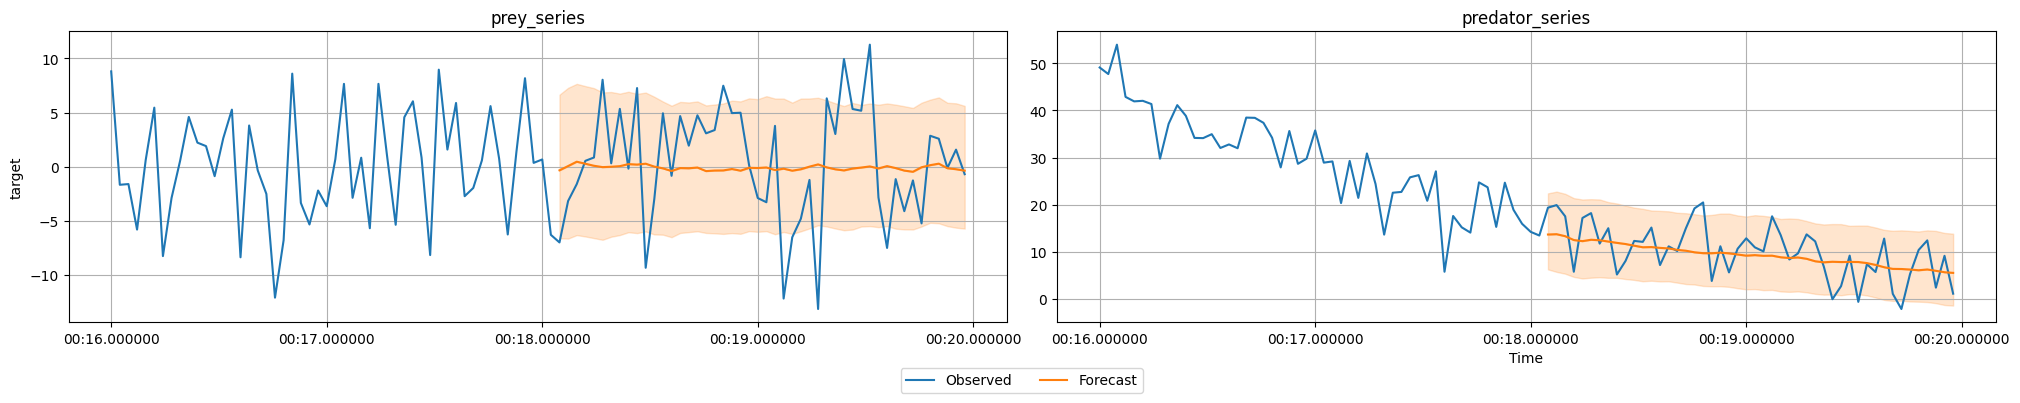

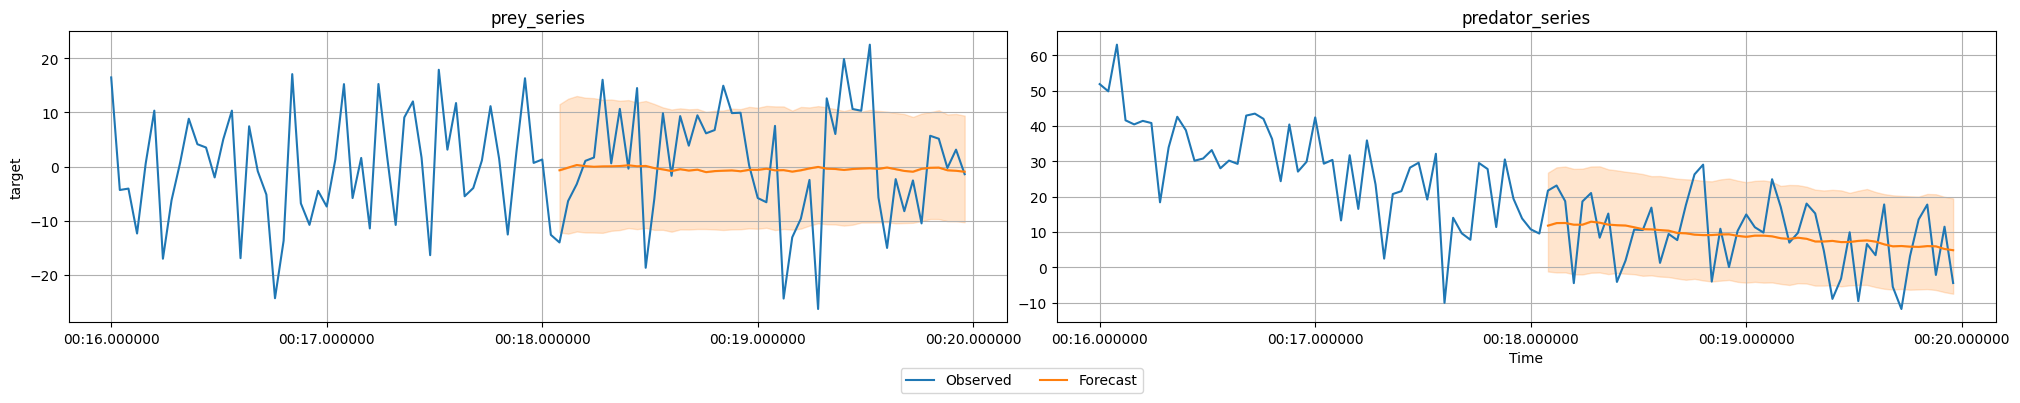

In [33]:
# Function to evaluate performance for different noise levels
def evaluate_noise_impact(noise_levels):
    results = []
    for noise in noise_levels:
        # Add Gaussian noise to prey and predator populations
        noisy_prey = prey + np.random.normal(0, noise, size=prey.shape)
        noisy_predator = predator + np.random.normal(0, noise, size=predator.shape)

        # Prepare data
        timestamps = pd.date_range(start="2025-01-01", periods=len(time_points), freq="0.04s")  # Use lowercase "s"
        prey_data = pd.DataFrame({"item_id": "prey_series", "timestamp": timestamps, "target": noisy_prey})
        predator_data = pd.DataFrame({"item_id": "predator_series", "timestamp": timestamps, "target": noisy_predator})
        combined_data = pd.concat([prey_data, predator_data], ignore_index=True)
        noisy_data = TimeSeriesDataFrame.from_data_frame(combined_data)

        # Split into train/test
        train_data, test_data = noisy_data.train_test_split(prediction_length=48)

        # Create a new predictor for each noise level
        noise_predictor = TimeSeriesPredictor(prediction_length=prediction_length).fit(
            train_data=train_data, hyperparameters={
                "Chronos":
                    {"model_path": "bolt_mini", "fine_tune": True},
            },time_limit=600,
        )

        # Generate predictions
        predictions = noise_predictor.predict(train_data)

        # Visualize the predictions for both prey and predator
        noise_predictor.plot(
            data=noisy_data,
            predictions=predictions,
            item_ids=data.item_ids[:2],  # Plot the first two series (prey and predator)
            max_history_length=100,
        )

        # Ensure only the forecast horizon is included in actual data
        prey_actual = test_data.loc["prey_series"][-48:]["target"]
        prey_forecast = predictions.loc["prey_series", "mean"]
        mae_prey = mean_absolute_error(prey_actual, prey_forecast)
        rmse_prey = np.sqrt(mean_squared_error(prey_actual, prey_forecast))

        predator_actual = test_data.loc["predator_series"][-48:]["target"]
        predator_forecast = predictions.loc["predator_series", "mean"]
        mae_predator = mean_absolute_error(predator_actual, predator_forecast)
        rmse_predator = np.sqrt(mean_squared_error(predator_actual, predator_forecast))

        results.append({
            "Noise Level": noise,
            "MAE (Prey)": mae_prey,
            "RMSE (Prey)": rmse_prey,
            "MAE (Predator)": mae_predator,
            "RMSE (Predator)": rmse_predator
        })

    return pd.DataFrame(results)



# Analyze noise impact
noise_levels = [0,1.0, 5.0, 10.0]
results = evaluate_noise_impact(noise_levels)
print(results)


## Step 8: Visualize Noise Impact
We plot the results of the noise impact analysis to see how increasing noise levels affect forecasting accuracy.


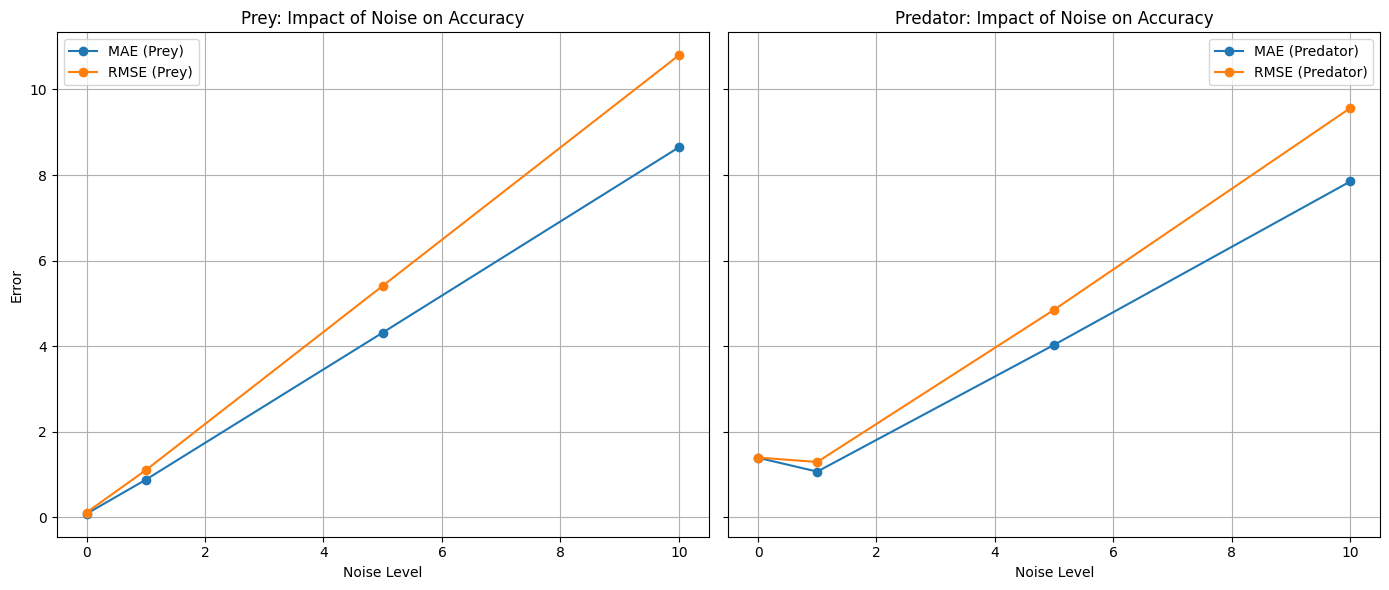

In [34]:
# Plot MAE and RMSE for Prey and Predator
fig, ax = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Prey
ax[0].plot(results["Noise Level"], results["MAE (Prey)"], label="MAE (Prey)", marker="o")
ax[0].plot(results["Noise Level"], results["RMSE (Prey)"], label="RMSE (Prey)", marker="o")
ax[0].set_title("Prey: Impact of Noise on Accuracy")
ax[0].set_xlabel("Noise Level")
ax[0].set_ylabel("Error")
ax[0].legend()
ax[0].grid()

# Predator
ax[1].plot(results["Noise Level"], results["MAE (Predator)"], label="MAE (Predator)", marker="o")
ax[1].plot(results["Noise Level"], results["RMSE (Predator)"], label="RMSE (Predator)", marker="o")
ax[1].set_title("Predator: Impact of Noise on Accuracy")
ax[1].set_xlabel("Noise Level")
ax[1].legend()
ax[1].grid()

plt.tight_layout()
plt.show()


## Conclusion
- **Forecast Accuracy**: The model performs well under low noise levels, with reasonable MAE and RMSE values for both prey and predator.
- **Noise Impact**: Increasing noise levels reduce forecasting accuracy, as observed from the error metrics.

